In [1]:
%matplotlib inline


# Canonical Poisson Distribution


This is an example demonstrating how pyglmnet with
poisson exponential distribution works.



First, we can import useful libraries that we will use it later on


In [2]:
import numpy as np
import scipy.sparse as sps
from scipy.special import expit
from copy import deepcopy
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

Import ``GLM`` class from ``pyglmnet``


In [3]:
# import GLM model
from pyglmnet import GLM

# create regularization parameters for model
reg_lambda = np.logspace(np.log(0.5), np.log(0.01), 10, base=np.exp(1))
glm_poissonexp = GLM(distr='poissonexp', verbose=False, alpha=0.05,
            max_iter=1000, learning_rate=1e-5,
            reg_lambda=reg_lambda, eta=4.0)



$$J = \sum_i \lambda_i - y_i \log \lambda_i$$

where

$$\lambda_i =
    \begin{cases}
        \exp(z_i), & \text{if}\ z_i \leq \eta \\
        \\
         \exp(\eta)z_i + (1-\eta)\exp(\eta), & \text{if}\ z_i \gt \eta
    \end{cases}$$

and

$$z_i = \beta_0 + \sum_j \beta_j x_{ij}$$

Taking gradients,

$$\frac{\partial J}{\partial \beta_j} = \sum_i \frac{\partial J}{\partial \lambda_i} \frac{\partial \lambda_i}{\partial z_i} \frac{\partial z_i}{\partial \beta_j}$$


$$\frac{\partial J}{\partial \beta_0} =
    \begin{cases}
        \sum_i \Big(\lambda_i - y_i\Big), & \text{if}\ z_i \leq \eta \\
        \\
        \exp(\eta) \sum_i \Big(1 - \frac{\lambda_i}{y_i}\Big), & \text{if}\ z_i \gt \eta
    \end{cases}$$

$$\frac{\partial J}{\partial \beta_j} =
    \begin{cases}
        \sum_i \Big(\lambda_i - y_i\Big)x_{ij}, & \text{if}\ z_i \leq \eta \\
        \\
        \exp(\eta) \sum_i \Big(1 - \frac{\lambda_i}{y_i}\Big)x_{ij}, & \text{if}\ z_i \gt \eta
    \end{cases}$$





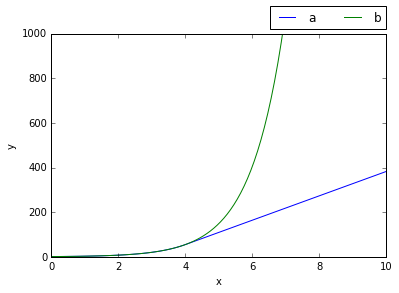

In [4]:
z = np.linspace(0., 10., 100)

eta = 4.0
qu = deepcopy(z)
slope = np.exp(eta)
intercept = (1 - eta) * slope
qu[z > eta] = z[z > eta] * slope + intercept
qu[z <= eta] = np.exp(z[z <= eta])

plt.plot(z, qu, label='a')
plt.plot(z, np.exp(z), label='b')
plt.ylim([0, 1000])
plt.xlabel('x')
plt.ylabel('y')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=1,
           ncol=2, borderaxespad=0.)
plt.show()

In [5]:
# Dataset size
n_samples, n_features = 10000, 100

# baseline term
beta0 = np.random.normal(0.0, 1.0, 1)
# sparse model terms
beta = sps.rand(n_features, 1, 0.1)
beta = np.array(beta.todense())

# training data
Xr = np.random.normal(0.0, 1.0, [n_samples, n_features])
yr = glm_poissonexp.simulate(beta0, beta, Xr)

# testing data
Xt = np.random.normal(0.0, 1.0, [n_samples, n_features])
yt = glm_poissonexp.simulate(beta0, beta, Xt)

Fit model to training data


In [6]:
scaler = StandardScaler().fit(Xr)
glm_poissonexp.fit(scaler.transform(Xr),yr);

/usr/local/lib/python2.7/dist-packages/pyglmnet-0.1.dev0-py2.7.egg/pyglmnet/pyglmnet.py:334: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/pyglmnet-0.1.dev0-py2.7.egg/pyglmnet/pyglmnet.py:352: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/pyglmnet-0.1.dev0-py2.7.egg/pyglmnet/pyglmnet.py:356: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Gradient of loss function


In [7]:
grad_beta0, grad_beta = glm_poissonexp._grad_L2loss(glm_poissonexp.fit_[-1]['beta0'], glm_poissonexp.fit_[-1]['beta'], 0.01, Xr, yr)
print(grad_beta[:5])

[[-0.77386543]
 [ 0.5081026 ]
 [ 0.70967578]
 [ 0.7034753 ]
 [-0.40775273]]


Use one model to predict


In [8]:
m = glm_poissonexp[-1]
this_model_param = m.fit_
yrhat = m.predict(scaler.transform(Xr))
ythat = m.predict(scaler.transform(Xt))

Visualize predicted output


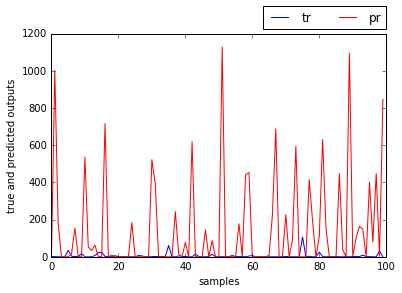

In [9]:
plt.plot(yt[:100], label='tr')
plt.plot(ythat[:100], 'r', label='pr')
plt.xlabel('samples')
plt.ylabel('true and predicted outputs')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=1,
           ncol=2, borderaxespad=0.)
plt.show()

compute pseudo R-square


In [10]:
print(m.score(yt, ythat, np.mean(yr), method='pseudo_R2'))

-30.6596721987
